In [10]:
import csv
import pandas as pd
import seaborn as sns

# Path to your csv file
file_path = 'user_courses_review_test_set.csv'

# A list to hold rows of data
data_list = []

# Number of columns expected per row
EXPECTED_COLUMNS = 4  # Change this to the number of columns you expect

# Open the file and read each row
with open(file_path, mode='r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    
    # Optionally, capture the header (first row) if it exists
    header = next(reader)
    
    # Read each row
    for row in reader:
        # Check if the row has the expected number of columns
        if len(row) == EXPECTED_COLUMNS:
            # If the row is as expected, append it to the list
            data_list.append(row)
        else:
            # If not, handle it: skip, log, etc.
            print(f"Skipping row {reader.line_num}: {row}")

# Convert the list of data into a pandas DataFrame
data = pd.DataFrame(data_list, columns=header)  # Include columns parameter if header was captured

# Show the first few rows of the dataframe
print(data.head())

                             course_name  \
0               Advanced Microsoft Excel   
1     Agile and Scrum Project Management   
2   AI Applications for Business Success   
3   AI Applications for Business Success   
4  Building a 3-Statement Model in Excel   

                                        lecture_name review_rating  \
0            F1 to F12 - Using Excel's Function Keys             5   
1                   Agile vs Waterfall - Conclusions             1   
2                          Correlation vs. Causation             3   
3                          Correlation vs. Causation             3   
4  Calculating Cash Flows and Completing the Mode...             5   

                                      review_comment  
0                                           perfect   
1               The SCRUM chapter are full of errors  
2                Bad quality of audio and narrative   
3                I need documentation about lecture.  
4  Great course! Ned has a talent for e

In [11]:
# Check data types of the columns
data_types = data.dtypes

# Convert 'review_rating' to a numeric type if it's currently an object (string)
if data['review_rating'].dtype == 'object':
    # Force invalid parsing to NaN so we can find and analyze these rows later
    data['review_rating'] = pd.to_numeric(data['review_rating'], errors='coerce')

# Check the new data types and find the number of missing values after conversion
new_data_types = data.dtypes
missing_values = data.isnull().sum()

data_types, new_data_types, missing_values


(course_name       object
 lecture_name      object
 review_rating     object
 review_comment    object
 dtype: object,
 course_name       object
 lecture_name      object
 review_rating      int64
 review_comment    object
 dtype: object,
 course_name       0
 lecture_name      0
 review_rating     0
 review_comment    0
 dtype: int64)

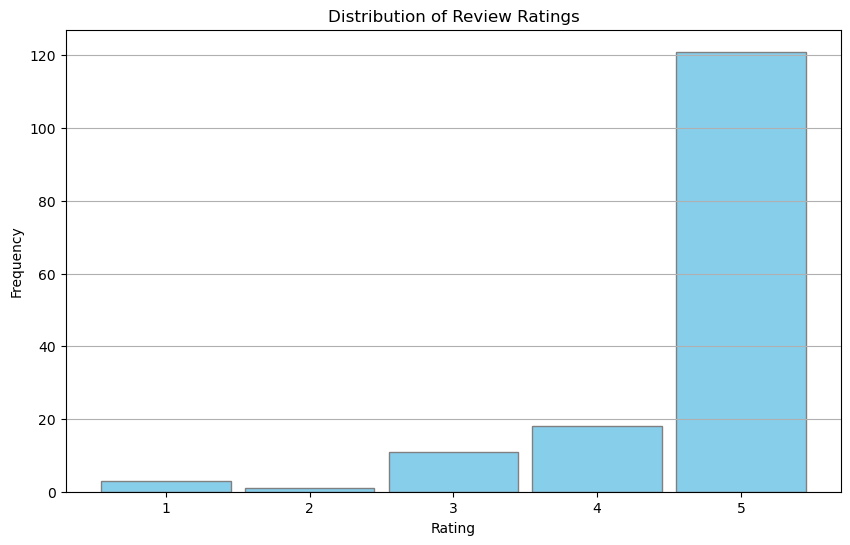

count    154.000000
mean       4.642857
std        0.805849
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: review_rating, dtype: float64

In [12]:
import matplotlib.pyplot as plt

# Summary statistics for 'review_rating'
review_rating_stats = data['review_rating'].describe()

# Distribution of 'review_rating'
plt.figure(figsize=(10, 6))
plt.hist(data['review_rating'].dropna(), bins=range(1, 7), align='left', rwidth=0.9, color='skyblue', edgecolor='gray')
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.grid(axis='y')
plt.show()

review_rating_stats


In [17]:
# Remove rows with missing values
clean_data = data.dropna()

# Check the new shape of the data
new_shape = clean_data.shape

# For correlation analysis, we first need to add a new column for the length of the comments
clean_data['comment_length'] = clean_data['review_comment'].apply(len)

# Calculate the correlation between 'review_rating' and 'comment_length'
correlation = clean_data[['review_rating', 'comment_length']].corr()

new_shape, correlation


((154, 4),
                 review_rating  comment_length
 review_rating        1.000000       -0.130977
 comment_length      -0.130977        1.000000)

In [18]:
import re

# Define regex patterns to look for emphasis and sentiment
patterns = {
    "positive_emphasis": re.compile(r'\b(great|good|excellent|amazing|love|best|awesome|fantastic)\b', re.IGNORECASE),
    "negative_emphasis": re.compile(r'\b(bad|terrible|awful|poor|worst|hate|disappoint)\b', re.IGNORECASE),
    "question": re.compile(r'\?'),
    "exclamation": re.compile(r'!'),
    "capital_words": re.compile(r'\b[A-Z]{2,}\b')  # words with all letters capitalized, and at least two characters long
}

# Initialize a dictionary to hold the counts of each pattern
pattern_counts = {key: 0 for key in patterns}

# Scan each review and count the occurrences of each pattern
for review in clean_data['review_comment']:
    for key, pattern in patterns.items():
        if re.search(pattern, review):
            pattern_counts[key] += 1

pattern_counts


{'positive_emphasis': 82,
 'negative_emphasis': 1,
 'question': 0,
 'exclamation': 20,
 'capital_words': 9}

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import string

# Function for text cleaning and normalization
def clean_text(text):
    text = text.lower()  # convert text to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    return text

# Apply the function to clean the reviews
clean_data.loc[:, 'review_comment'] = clean_data.loc[:, 'review_comment'].apply(clean_text)

# Split data into features (X) and target label (y)
X = clean_data.loc[:, 'review_comment']
y = clean_data.loc[:, 'review_comment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [20]:
# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Initialize the Multinomial Naive Bayes classifier
model = MultinomialNB()

# Create a pipeline that first vectorizes the text data then applies the Naive Bayes classifier
text_clf = make_pipeline(vectorizer, model)

# Train the model with the training data
text_clf.fit(X_train, y_train)

# Predict the categories of the test data
y_pred = text_clf.predict(X_test)

# Calculate the classification report
report = classification_report(y_test, y_pred)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

report, conf_matrix

C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('                                                                                                                                                                                                                                                                                                                                                                                                                                 precision    recall  f1-score   support\n\n                                                                                                                                                                                                                                                                                                                                                                                                                                      0.00      0.00      0.00         1\n                                                                                

In [21]:
from sklearn.utils import resample

# Separate the majority and minority classes
df_majority = clean_data[clean_data.review_rating == 5]
df_minority = clean_data[clean_data.review_rating < 5]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.review_rating.value_counts()


review_rating
5    121
4     73
3     34
1     12
2      2
Name: count, dtype: int64

In [22]:
# Split the upsampled data into features (X) and target label (y)
X_upsampled = df_upsampled['review_comment']
y_upsampled = df_upsampled['review_rating']

# Split the upsampled data into training and testing sets
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(
    X_upsampled, y_upsampled, test_size=0.2, random_state=42)

# Train the model with the upsampled training data
text_clf_upsampled = make_pipeline(vectorizer, model)
text_clf_upsampled.fit(X_train_upsampled, y_train_upsampled)

# Predict the categories of the upsampled test data
y_pred_upsampled = text_clf_upsampled.predict(X_test_upsampled)

# Calculate the classification report for the upsampled data
report_upsampled = classification_report(y_test_upsampled, y_pred_upsampled)

# Calculate the confusion matrix for the upsampled data
conf_matrix_upsampled = confusion_matrix(y_test_upsampled, y_pred_upsampled)

report_upsampled, conf_matrix_upsampled


C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('              precision    recall  f1-score   support\n\n           1       1.00      0.33      0.50         3\n           2       0.00      0.00      0.00         1\n           3       1.00      0.33      0.50         6\n           4       0.75      0.92      0.83        13\n           5       0.77      0.88      0.82        26\n\n    accuracy                           0.78        49\n   macro avg       0.70      0.49      0.53        49\nweighted avg       0.79      0.78      0.75        49\n',
 array([[ 1,  0,  0,  0,  2],
        [ 0,  0,  0,  0,  1],
        [ 0,  0,  2,  1,  3],
        [ 0,  0,  0, 12,  1],
        [ 0,  0,  0,  3, 23]], dtype=int64))

## Classification task

C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


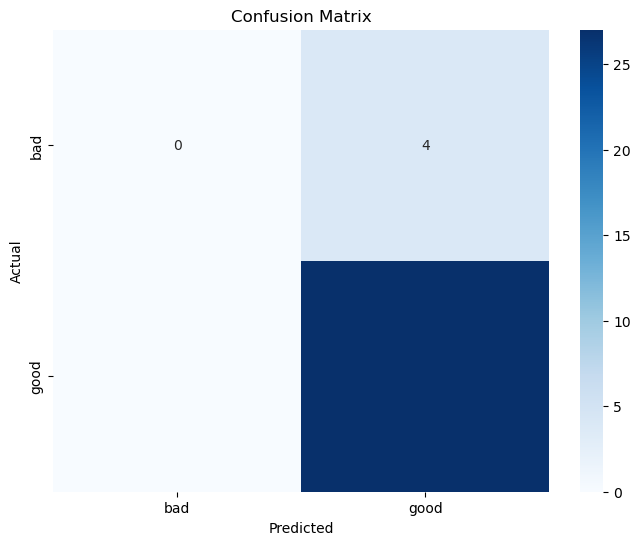

,precision,recall,f1-score,support
bad,0.000000,0.000000,0.000000,4.000000
good,0.870968,1.000000,0.931034,27.000000
accuracy,0.870968,0.870968,0.870968,0.870968
macro avg,0.435484,0.500000,0.465517,31.000000
weighted avg,0.758585,0.870968,0.810901,31.000000


In [23]:
# Define a function to convert ratings into 'good' and 'bad'
def binary_rating(rating):
    if rating >= 4:
        return 'good'
    else:
        return 'bad'

# Apply the function to the 'review_rating' column
binary_data = clean_data.copy()
binary_data['review_rating'] = binary_data['review_rating'].apply(binary_rating)

# Split data into features (X) and target label (y)
X_binary = binary_data['review_comment']
y_binary = binary_data['review_rating']

# Split the data into training and testing sets
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42)

# Train the model with the binary training data
text_clf_binary = make_pipeline(vectorizer, model)
text_clf_binary.fit(X_train_binary, y_train_binary)

# Predict the categories of the binary test data
y_pred_binary = text_clf_binary.predict(X_test_binary)

# Calculate the classification report for the binary data
report_binary = classification_report(y_test_binary, y_pred_binary, output_dict=True)

# Calculate the confusion matrix for the binary data
conf_matrix_binary = confusion_matrix(y_test_binary, y_pred_binary)

# Convert classification report to DataFrame for better visualization
report_binary_df = pd.DataFrame(report_binary).transpose()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

report_binary_df


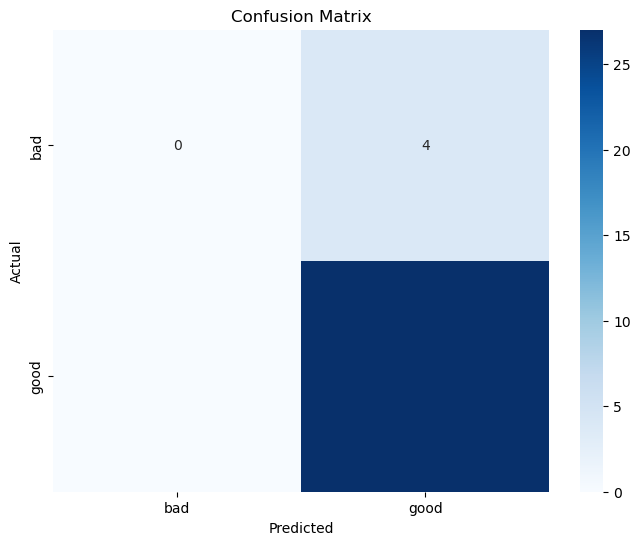

,precision,recall,f1-score,support
bad,0.000000,0.000000,0.000000,4.000000
good,0.870968,1.000000,0.931034,27.000000
accuracy,0.870968,0.870968,0.870968,0.870968
macro avg,0.435484,0.500000,0.465517,31.000000
weighted avg,0.758585,0.870968,0.810901,31.000000


In [24]:


# Redo the confusion matrix plot with seaborn now imported
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

report_binary_df


In [25]:
# Separate the majority and minority classes
df_majority_binary = binary_data[binary_data.review_rating == 'good']
df_minority_binary = binary_data[binary_data.review_rating == 'bad']

# Oversample minority class
df_minority_upsampled_binary = resample(df_minority_binary, 
                                        replace=True,     # sample with replacement
                                        n_samples=len(df_majority_binary),    # to match majority class
                                        random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled_binary = pd.concat([df_majority_binary, df_minority_upsampled_binary])

# Display new class counts
df_upsampled_binary.review_rating.value_counts()


review_rating
good    139
bad     139
Name: count, dtype: int64

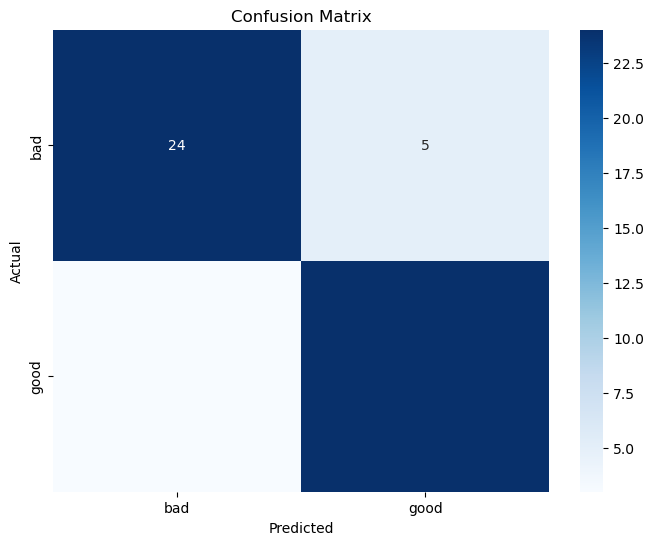

,precision,recall,f1-score,support
bad,0.888889,0.827586,0.857143,29.000000
good,0.827586,0.888889,0.857143,27.000000
accuracy,0.857143,0.857143,0.857143,0.857143
macro avg,0.858238,0.858238,0.857143,56.000000
weighted avg,0.859332,0.857143,0.857143,56.000000


In [26]:
# Split the upsampled binary data into features (X) and target label (y)
X_upsampled_binary = df_upsampled_binary['review_comment']
y_upsampled_binary = df_upsampled_binary['review_rating']

# Split the upsampled data into training and testing sets
X_train_upsampled_binary, X_test_upsampled_binary, y_train_upsampled_binary, y_test_upsampled_binary = train_test_split(
    X_upsampled_binary, y_upsampled_binary, test_size=0.2, random_state=42)

# Train the model with the upsampled binary training data
text_clf_upsampled_binary = make_pipeline(vectorizer, model)
text_clf_upsampled_binary.fit(X_train_upsampled_binary, y_train_upsampled_binary)

# Predict the categories of the upsampled binary test data
y_pred_upsampled_binary = text_clf_upsampled_binary.predict(X_test_upsampled_binary)

# Calculate the classification report for the upsampled binary data
report_upsampled_binary = classification_report(y_test_upsampled_binary, y_pred_upsampled_binary, output_dict=True)

# Calculate the confusion matrix for the upsampled binary data
conf_matrix_upsampled_binary = confusion_matrix(y_test_upsampled_binary, y_pred_upsampled_binary)

# Convert classification report to DataFrame for better visualization
report_upsampled_binary_df = pd.DataFrame(report_upsampled_binary).transpose()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_upsampled_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

report_upsampled_binary_df


## Test Set

In [27]:
# Load the test set, handling bad lines
test_set = pd.read_csv('user_courses_review_test_set.csv', error_bad_lines=False, warn_bad_lines=True)

# Remove rows with missing 'review_comment' or 'review_rating'
test_set_clean = test_set.dropna(subset=['review_comment', 'review_rating'])

# Convert 'review_rating' to float and handle potential conversion issues
test_set_clean['review_rating'] = pd.to_numeric(test_set_clean['review_rating'], errors='coerce')

# Check for any 'NaN' in 'review_rating' after conversion and remove those rows
test_set_clean = test_set_clean.dropna(subset=['review_rating'])

# Function to categorize reviews
def binary_rating(rating):
    # considering the rating is now a float, we'll compare with 4.0 instead of 4
    return 'good' if rating >= 4.0 else 'bad'

# Clean the 'review_comment' texts
test_set_clean['review_comment'] = test_set_clean['review_comment'].apply(clean_text)

# Apply the 'binary_rating' function to categorize 'review_rating'
test_set_clean['review_rating'] = test_set_clean['review_rating'].apply(binary_rating)

# Ensure the preprocessing steps have been successfully applied
preprocessed_test_set_clean_structure = test_set_clean.head()

# Prepare the features and labels from the cleaned test set for model application
X_test_set_clean = test_set_clean['review_comment']
y_test_set_clean = test_set_clean['review_rating']

# Use the trained model to predict the sentiments of the reviews in the cleaned test set
y_pred_test_set_clean = text_clf_upsampled_binary.predict(X_test_set_clean)

# Calculate the classification report for the cleaned test set predictions
report_test_set_clean = classification_report(y_test_set_clean, y_pred_test_set_clean, output_dict=True)

# Calculate the confusion matrix for the cleaned test set predictions
conf_matrix_test_set_clean = confusion_matrix(y_test_set_clean, y_pred_test_set_clean)

# Convert classification report to DataFrame for better visualization
report_test_set_clean_df = pd.DataFrame(report_test_set_clean).transpose()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test_set_clean, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

report_test_set_clean_df, preprocessed_test_set_clean_structure


TypeError: read_csv() got an unexpected keyword argument 'error_bad_lines'